# モデルの学習

In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import time

In [2]:
DATAPATH = "../../../data/DBLP/"
OUTPUTPATH = "../../../result/aminer/"

In [3]:
with open(DATAPATH + "keywords.txt") as f:
    keywords = list(map(lambda x: x.replace("\n", ""), f.readlines()))
key_sets = set(keywords)
len(keywords), keywords[0]

(1233, 'radiometry')

In [4]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import utils

from scipy.stats import pearsonr

In [5]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1233, 1233, 23), (1233, 1233), (1233, 1233, 23), (1233, 1233))

In [6]:
N = train_x.shape[0]
M = train_x.shape[2]
N, M

(1233, 23)

In [7]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((759528, 23), (759528,), (759528, 23), (759528,))

In [8]:
P = train_x.shape[0]
P

759528

In [9]:
model = LinearRegression()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))

フィッティング時間: 1.5966284163296223
スコア時間: 0.036412313580513


In [10]:
result = model.predict(test_x)
result_before = model.predict(train_x)
result.shape, result_before.shape

((759528,), (759528,))

In [11]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 19.009, MSE: 361.324, 相関係数: 0.828


In [12]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 12.33, MSE: 152.021, 相関係数: 0.525


In [13]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=False)
df["実測順位"] = df["実測"].rank(ascending=False)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.51

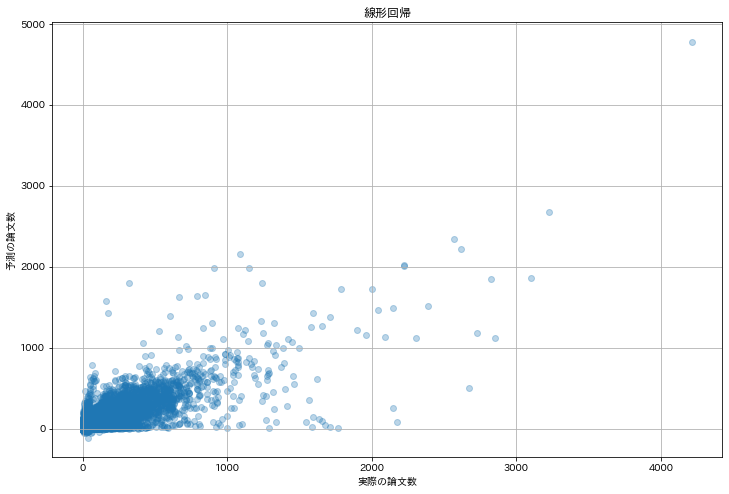

In [14]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.show()

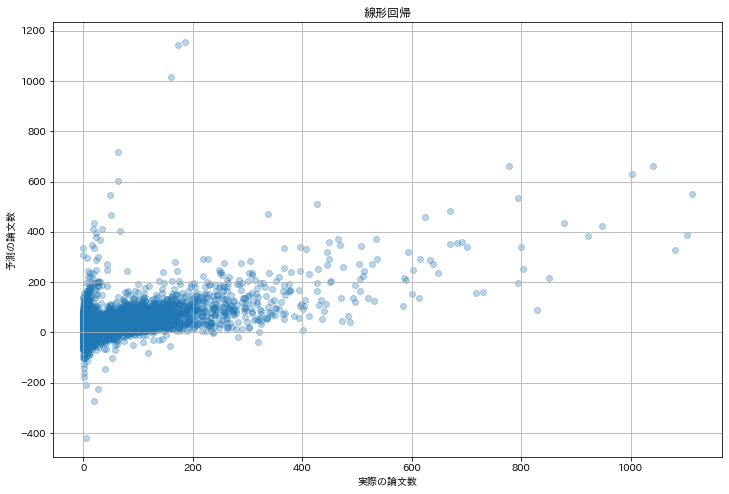

In [15]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.savefig(OUTPUTPATH+"img/lr.png")
fig.show()

In [16]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if x[i][j] > 400:
            print(word_matrix[i][j], round(x[i][j],1), correct_matrix[i][j])

['design' 'human factors'] 433.2 20.0
['design' 'performance'] 1142.1 173.0
['design' 'algorithms'] 1017.0 161.0
['design' 'experimentation'] 548.2 48.0
['theory' 'algorithms'] 405.0 67.0
['optimization' 'linear programming'] 459.1 625.0
['performance' 'algorithms'] 1154.2 185.0
['performance' 'measurement'] 466.8 50.0
['performance' 'experimentation'] 600.7 63.0
['algorithms' 'experimentation'] 716.6 64.0
['wireless communication' 'wireless sensor networks'] 551.9 1112.0
['wireless communication' 'interference'] 534.2 794.0
['sociology' 'statistics'] 661.9 777.0
['measurement' 'experimentation'] 410.5 35.0
['data models' 'computational modeling'] 425.0 947.0
['mathematical model' 'computational modeling'] 628.3 1002.0
['mobile computing' 'mobile communication'] 511.6 427.0
['visualization' 'feature extraction'] 435.6 878.0
['remote sensing' 'satellites'] 469.3 337.0
['noise' 'estimation'] 409.3 18.0
['interference' 'signal to noise ratio'] 663.1 1040.0
['switches' 'capacitors'] 481.5 

In [17]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if correct_matrix[i][j] > 400:
            print( word_matrix[i][j], round(x[i][j],1), correct_matrix[i][j])

['delays' 'optimization'] 66.9 413.0
['delays' 'wireless communication'] 112.6 443.0
['quality of service' 'resource management'] 210.1 589.0
['optimization' 'wireless communication'] 248.1 602.0
['optimization' 'mathematical model'] 370.6 534.0
['optimization' 'computational modeling'] 236.7 647.0
['optimization' 'resource management'] 388.9 1103.0
['optimization' 'interference'] 292.7 615.0
['optimization' 'linear programming'] 459.1 625.0
['optimization' 'robustness'] 259.6 475.0
['optimization' 'algorithm design and analysis'] 370.5 466.0
['optimization' 'convergence'] 286.9 633.0
['wireless communication' 'wireless sensor networks'] 551.9 1112.0
['wireless communication' 'resource management'] 338.9 799.0
['wireless communication' 'interference'] 534.2 794.0
['wireless communication' 'throughput'] 269.7 446.0
['wireless communication' 'signal to noise ratio'] 359.0 449.0
['wireless communication' 'receivers'] 156.5 717.0
['wireless communication' 'relays'] 137.0 492.0
['data minin

In [18]:
# weight = np.where(train_y == 0.0, True, False)  # if target == 0 : True else: False
# weight_inv = np.where(weight, False, True) # if target == 0 : False else: True

# # 0と1以上のデータを同数にする
# train_x_0, train_y_0 = train_x[weight], train_y[weight]
# train_x_1, train_y_1 = train_x[weight_inv], train_y[weight_inv]
# train_x_0, train_y_0 = utils.shuffle(train_x_0, train_y_0)
# train_x_0, train_y_0 = train_x_0[:len(train_x_1)], train_y_0[:len(train_y_1)]
# train_x, train_y = np.concatenate([train_x_0, train_x_1]), np.concatenate([train_y_0, train_y_1])

# print(train_x.shape, train_y.shape)
# print("0のデータ数: {}, 1以上のデータ数: {}".format(len(train_x_0), len(train_x_1)))

# 人気度

In [19]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y_diff.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y_diff.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1233, 1233, 23), (1233, 1233), (1233, 1233, 23), (1233, 1233))

In [20]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((759528, 23), (759528,), (759528, 23), (759528,))

In [21]:
model = LinearRegression()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))
result = model.predict(test_x)
result_before = model.predict(train_x)

フィッティング時間: 0.6761426255106926
スコア時間: 0.024423647671937943


In [22]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 19.009, MSE: 361.324, 相関係数: 0.785


In [23]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 12.33, MSE: 152.021, 相関係数: 0.959


In [24]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=True)
df["実測順位"] = df["実測"].rank(ascending=True)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.86

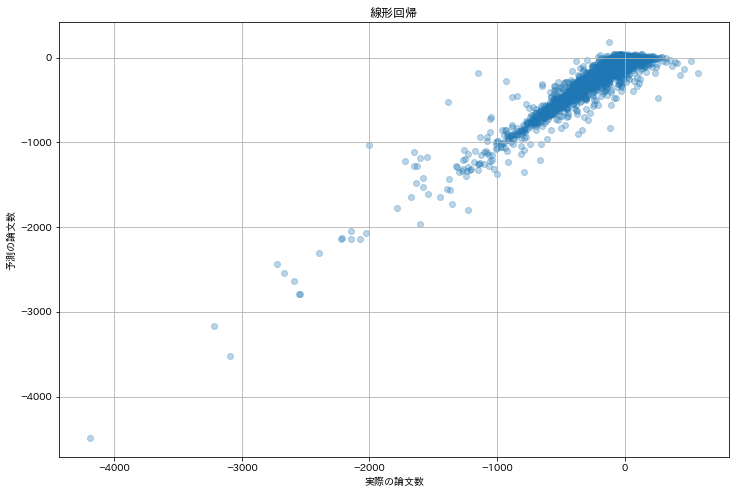

In [25]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.savefig(OUTPUTPATH+"img/lr_diff.png")
fig.show()

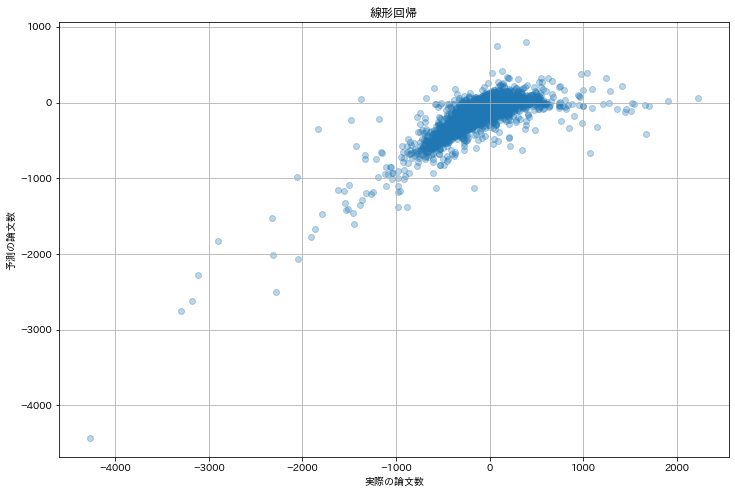

In [26]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
# fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

In [27]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if x[i][j] < -1500:
            print(word_matrix[i][j], round(x[i][j],1), correct_matrix[i][j])

['resource allocation' 'cloud computing'] -1646.8 -1445.0
['resource allocation' 'resource management'] -1644.2 -1672.0
['quality of service' 'qos'] -2145.6 -2074.0
['optimization' 'optimisation'] -2141.6 -2144.0
['bioinformatics' 'algorithms'] -3171.3 -3219.0
['bioinformatics' 'microarrays'] -2126.5 -2217.0
['bioinformatics' 'biomedical research'] -2434.2 -2723.0
['algorithms' 'microarrays'] -2139.3 -2222.0
['virtual machines' 'cloud computing'] -1556.9 -1371.0
['mobile computing' 'mobile communication'] -2311.4 -2396.0
['wireless sensor network' 'wireless sensor networks'] -4484.8 -4194.0
['genetic algorithm' 'genetic algorithms'] -2794.2 -2541.0
['mimo' 'mimo communication'] -1522.4 -1581.0
['feature extraction' 'image classification'] -2788.8 -2556.0
['feature extraction' 'support vector machines'] -1965.6 -1604.0
['feature extraction' 'image segmentation'] -1798.9 -1228.0
['computational modeling' 'computer model'] -2546.2 -2673.0
['support vector machine' 'support vector machines

In [29]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if correct_matrix[i][j] < -1500:
            print(i, j, word_matrix[i][j], round(x[i][j],1), correct_matrix[i][j])

20 42 ['design' 'performance'] -1030.9 -2000.0
20 79 ['design' 'measurement'] -1279.1 -1650.0
20 97 ['design' 'experimentation'] -1219.8 -1720.0
25 375 ['resource allocation' 'resource management'] -1644.2 -1672.0
26 1127 ['quality of service' 'qos'] -2145.6 -2074.0
41 365 ['optimization' 'optimisation'] -2141.6 -2144.0
41 421 ['optimization' 'vectors'] -1480.8 -1637.0
42 79 ['performance' 'measurement'] -1188.2 -1605.0
42 97 ['performance' 'experimentation'] -1113.3 -1651.0
50 65 ['bioinformatics' 'algorithms'] -3171.3 -3219.0
50 315 ['bioinformatics' 'microarrays'] -2126.5 -2217.0
50 337 ['bioinformatics' 'biomedical research'] -2434.2 -2723.0
65 315 ['algorithms' 'microarrays'] -2139.3 -2222.0
79 97 ['measurement' 'experimentation'] -1172.5 -1548.0
155 382 ['mobile computing' 'mobile communication'] -2311.4 -2396.0
227 367 ['wireless sensor network' 'wireless sensor networks'] -4484.8 -4194.0
293 431 ['genetic algorithm' 'genetic algorithms'] -2794.2 -2541.0
321 407 ['mimo' 'mimo co

In [33]:
train_y_s, test_y_s = np.load(DATAPATH + "train_y.npy"), np.load(DATAPATH + "test_y.npy")
train_y_s[772][774], test_y_s[772][774]

(1787.0, 2.0)